# Libraries

In [11]:
import tensorflow as tf
import random
import numpy as np
SEED = 10
random.seed(SEED)       # Sets seed for Python's built-in random module
np.random.seed(SEED)    # Sets seed for NumPy's random functions
tf.random.set_seed(SEED)  # Sets seed for TensorFlow's random operations

# Dataset

Minst Dataset

*   60,000 training images
*   10,000 test images
*   28x28 pixels (784 pixels)
*   Grayscale
*   Labled






In [12]:
# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Normalization
x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0

#One-Hot-Encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#Training Set
x_train_subset = x_train[:5000]
y_train_subset = y_train[:5000]

#Testing Set
x_test_subset = x_test[:10000]
y_test_subset = y_test[:10000]

# Neural Network

In [13]:
#ReLU activation (for hidden layer)
def relu(x):
    return np.maximum(0, x)

#Softmax activation (for output layer)
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))#We subtract to avoid big numbers when we take the exponential,This helps with numerical stability.
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Vector decoding (update dimensions to match 32 hidden units)
def decode_vector(vector):
    W1 = vector[0:25088].reshape((784, 32))
    b1 = vector[25088:25120].reshape((32,))
    W2 = vector[25120:25440].reshape((32, 10))
    b2 = vector[25440:25450].reshape((10,))
    return W1, b1, W2, b2

# Model forward pass
def forward(X, W1, b1, W2, b2):
    Z1 = X @ W1 + b1      # Linear part
    A1 = relu(Z1)         # Apply ReLU
    Z2 = A1 @ W2 + b2     # Linear part
    A2 = softmax(Z2)      # Apply softmax
    return A2

def cross_entropy(preds, targets, eps=1e-12):
    preds = np.clip(preds, eps, 1 - eps)  # Avoid log(0) which is undefined and log(1) as it is = 0 , range = (eps , 1 - eps)
    return -np.mean(np.sum(targets * np.log(preds), axis=1))

def fitness_function(vector):
    #Vector Decoding
    W1, b1, W2, b2 = decode_vector(vector)

    #Forward pass
    probs = forward(x_train_subset, W1, b1, W2, b2)

    #Cross-entropy loss
    ce_loss = cross_entropy(probs, y_train_subset)

    return ce_loss

# He initialization for 32 ReLU units , ""weight = np.random.randn(...) * sqrt(2 / n)""scaling the randoms
def he_vector(input_dim=784, hidden_dim=32, output_dim=10):
    w1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / input_dim)
    b1 = np.zeros(hidden_dim)
    w2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / hidden_dim)
    b2 = np.zeros(output_dim)
    return np.concatenate([w1.flatten(), b1, w2.flatten(), b2])

# GA Methods

**Selection**

In [14]:
#Parent Selection
def tournament_selection(population, fitness, k=3):
    indices = np.random.choice(len(population), k, replace=False)
    best_idx = indices[np.argmin(fitness[indices])]
    return population[best_idx]

#Survivor Selection
def elitism(parents, parent_fitness, offspring, offspring_fitness, num_elites=2):
    # Select best 'num_elites' parents (lowest loss)
    elite_indices = np.argpartition(parent_fitness, num_elites)[:num_elites]
    elites = parents[elite_indices]
    elite_fitness = parent_fitness[elite_indices]

    # Select best offspring to fill remaining spots
    num_remaining = len(parents) - num_elites
    best_offspring_indices = np.argpartition(offspring_fitness, num_remaining)[:num_remaining]
    selected_offspring = offspring[best_offspring_indices]
    selected_offspring_fitness = offspring_fitness[best_offspring_indices]

    # Combine elites and selected offspring
    new_population = np.vstack((elites, selected_offspring))
    new_fitness = np.concatenate((elite_fitness, selected_offspring_fitness))

    return new_population, new_fitness

**Crossover**

In [15]:
def blx_alpha_crossover(p1, p2, alpha = 0.1):
    p1, p2 = np.array(p1), np.array(p2)
    assert p1.shape == p2.shape, "Parents must have the same shape"
    diff = np.abs(p1 - p2)
    low = np.minimum(p1, p2) - alpha * diff
    high = np.maximum(p1, p2) + alpha * diff
    return np.random.uniform(low, high) , np.random.uniform(low, high)

**Mutation**

In [16]:
def gaussian_mutation(individual,sigma=0.1 , rate=0.01):
    individual = np.asarray(individual)
    mutant = individual.copy()
    mask = np.random.rand(*mutant.shape) < rate
    if np.any(mask):
        mutant[mask] += np.random.normal(0, sigma, size=np.sum(mask))
    return mutant

**Parallel**

In [ ]:
from joblib import Parallel, delayed 
# === Parallel fitness evaluation helper ===
def parallel_fitness(pop):
    return np.array(Parallel(n_jobs=-1)(delayed(fitness_function)(ind) for ind in pop))

# GA

In [18]:
def ga(vector_size, population_size=20, generations=3000):
    population = np.array([he_vector() for _ in range(population_size)])
    fitness = np.array([fitness_function(ind) for ind in population])
    loss_history = []
    
    for gen in range(generations):
        offspring = []
        
        for i in range(population_size // 2):
            #Parent Selection
            p1 = tournament_selection(population, fitness, k=3)
            p2 = tournament_selection(population, fitness, k=3)

            # Crossover
            c1, c2 = blx_alpha_crossover(p1, p2)

            # Mutation
            c1 = gaussian_mutation(c1)
            c2 = gaussian_mutation(c2)

            offspring.extend([c1, c2])

        # Evaluate fitness
        offspring = np.array(offspring)
        offspring_fitness = parallel_fitness(offspring)

        # Survivor selection
        new_pop, new_fit = elitism(population, fitness, offspring, offspring_fitness, num_elites=2)

        population = new_pop
        fitness = new_fit
        
        # --- Logging ---
        best_loss = np.min(fitness)
        loss_history.append(best_loss)
        if gen % 100 == 0:
            print(f"Gen {gen+1:03d} | Best Loss: {np.min(fitness):.4f} | Avg Loss: {np.mean(fitness):.4f}")

    best_idx = np.argmin(fitness)
    return population[best_idx], fitness[best_idx], population, fitness , loss_history

# Run

In [19]:
# Set seed for reproducibility
np.random.seed(SEED)
best_solution, best_fitness, population , fitness , loss_history = ga(vector_size=25450)

Gen 001 | Best Loss: 2.2791 | Avg Loss: 2.3355
Gen 101 | Best Loss: 1.5613 | Avg Loss: 1.5716
Gen 201 | Best Loss: 0.9539 | Avg Loss: 0.9686
Gen 301 | Best Loss: 0.6803 | Avg Loss: 0.6863
Gen 401 | Best Loss: 0.5330 | Avg Loss: 0.5398
Gen 501 | Best Loss: 0.4592 | Avg Loss: 0.4624
Gen 601 | Best Loss: 0.4035 | Avg Loss: 0.4088
Gen 701 | Best Loss: 0.3650 | Avg Loss: 0.3695
Gen 801 | Best Loss: 0.3441 | Avg Loss: 0.3498
Gen 901 | Best Loss: 0.3196 | Avg Loss: 0.3224
Gen 1001 | Best Loss: 0.2989 | Avg Loss: 0.3019
Gen 1101 | Best Loss: 0.2797 | Avg Loss: 0.2831
Gen 1201 | Best Loss: 0.2657 | Avg Loss: 0.2690
Gen 1301 | Best Loss: 0.2537 | Avg Loss: 0.2572
Gen 1401 | Best Loss: 0.2479 | Avg Loss: 0.2507
Gen 1501 | Best Loss: 0.2361 | Avg Loss: 0.2392
Gen 1601 | Best Loss: 0.2303 | Avg Loss: 0.2325
Gen 1701 | Best Loss: 0.2228 | Avg Loss: 0.2249
Gen 1801 | Best Loss: 0.2189 | Avg Loss: 0.2221
Gen 1901 | Best Loss: 0.2158 | Avg Loss: 0.2187
Gen 2001 | Best Loss: 0.2105 | Avg Loss: 0.2140
Ge

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [21]:
# Decode weights and predict
decoded_weights = decode_vector(best_solution)
predictions_test = forward(x_test_subset, *decoded_weights)
predictions_train = forward(x_train_subset, *decoded_weights)

# Labels and accuracy
predicted_labels = np.argmax(predictions_test, axis=1)
true_labels = np.argmax(y_test_subset, axis=1)
test_accuracy = np.mean(predicted_labels == true_labels)
train_accuracy = np.mean(np.argmax(predictions_train, axis=1) == np.argmax(y_train_subset, axis=1))

print(f"\nFinal Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Final Train Accuracy: 94.92%
Final Test Accuracy: 89.03%


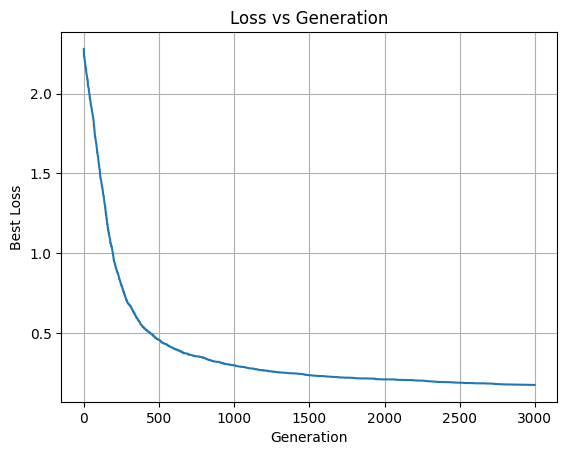

In [22]:
# Plot loss per generation
plt.plot(loss_history, label='Loss')
plt.xlabel('Generation')
plt.ylabel('Best Loss')
plt.title('Loss vs Generation')
plt.grid(True)
plt.show()

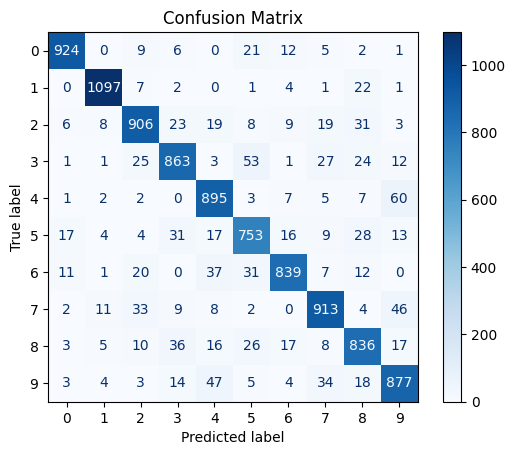

In [23]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

# DE

In [35]:
def de(vector_size , population, fitness , generations = 3000 ,pop_size = 20 , F = 0.5, CR = 0.7):
    loss_history = []

    for gen in range(generations):
        #To store offsprings
        new_pop = np.zeros_like(population)
        new_fit = np.zeros(pop_size)

        for i in range(pop_size):
            #Parent Selection
            idxs = np.delete(np.arange(pop_size), i)#Target Vector

            #Mutation
            v1, v2, v3 = population[np.random.choice(idxs, 3, replace=False)]
            mutant = v1 + F * (v2 - v3)#Mutant Vector

            #Crossover
            cross_points = np.random.rand(vector_size) < CR
            if not np.any(cross_points):
                cross_points[np.random.randint(vector_size)] = True

            trial = np.where(cross_points, mutant, population[i])
            trial_fitness = fitness_function(trial)

            #Survivor Selection
            if trial_fitness <= fitness[i]:
                new_pop[i] = trial
                new_fit[i] = trial_fitness
            else:
                new_pop[i] = population[i]
                new_fit[i] = fitness[i]

        population = np.array(new_pop)
        fitness = np.array(new_fit)

        # --- Logging ---
        best_loss = np.min(fitness)
        loss_history.append(best_loss)
        if gen % 100 == 0:
            print(f"Gen {gen+1:03d} | Best Loss: {np.min(fitness):.4f} | Avg Loss: {np.mean(fitness):.4f}")

    best_idx = np.argmin(fitness)
    return population[best_idx] , loss_history

# Run

In [36]:
# Set seed for reproducibility
np.random.seed(SEED)
best_solution, loss_history = de(population = population , fitness = fitness ,vector_size=25450)

Gen 001 | Best Loss: 0.1757 | Avg Loss: 0.1778
Gen 101 | Best Loss: 0.1708 | Avg Loss: 0.1711
Gen 201 | Best Loss: 0.1682 | Avg Loss: 0.1683
Gen 301 | Best Loss: 0.1668 | Avg Loss: 0.1669
Gen 401 | Best Loss: 0.1652 | Avg Loss: 0.1653
Gen 501 | Best Loss: 0.1638 | Avg Loss: 0.1639
Gen 601 | Best Loss: 0.1627 | Avg Loss: 0.1627
Gen 701 | Best Loss: 0.1611 | Avg Loss: 0.1612
Gen 801 | Best Loss: 0.1600 | Avg Loss: 0.1600
Gen 901 | Best Loss: 0.1588 | Avg Loss: 0.1589
Gen 1001 | Best Loss: 0.1579 | Avg Loss: 0.1579
Gen 1101 | Best Loss: 0.1570 | Avg Loss: 0.1571
Gen 1201 | Best Loss: 0.1563 | Avg Loss: 0.1563
Gen 1301 | Best Loss: 0.1550 | Avg Loss: 0.1551
Gen 1401 | Best Loss: 0.1543 | Avg Loss: 0.1543
Gen 1501 | Best Loss: 0.1537 | Avg Loss: 0.1538
Gen 1601 | Best Loss: 0.1531 | Avg Loss: 0.1531
Gen 1701 | Best Loss: 0.1524 | Avg Loss: 0.1525
Gen 1801 | Best Loss: 0.1517 | Avg Loss: 0.1517
Gen 1901 | Best Loss: 0.1512 | Avg Loss: 0.1512
Gen 2001 | Best Loss: 0.1506 | Avg Loss: 0.1507
Ge

In [37]:
# Decode weights and predict
decoded_weights = decode_vector(best_solution)
predictions_test = forward(x_test_subset, *decoded_weights)
predictions_train = forward(x_train_subset, *decoded_weights)

# Labels and accuracy
predicted_labels = np.argmax(predictions_test, axis=1)
true_labels = np.argmax(y_test_subset, axis=1)
test_accuracy = np.mean(predicted_labels == true_labels)
train_accuracy = np.mean(np.argmax(predictions_train, axis=1) == np.argmax(y_train_subset, axis=1))

print(f"\nFinal Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Final Train Accuracy: 96.10%
Final Test Accuracy: 89.50%


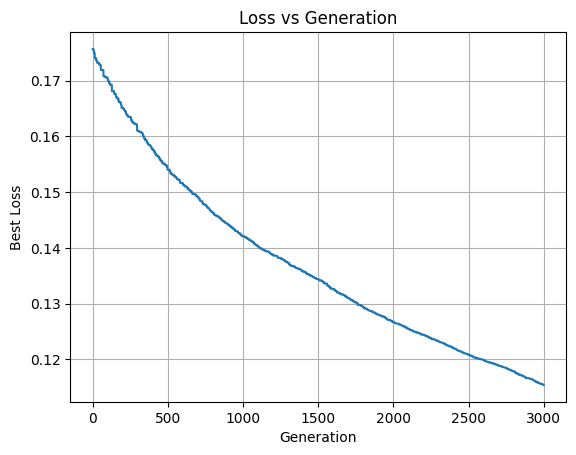

In [27]:
# Plot loss per generation
plt.plot(loss_history, label='Loss')
plt.xlabel('Generation')
plt.ylabel('Best Loss')
plt.title('Loss vs Generation')
plt.grid(True)
plt.show()

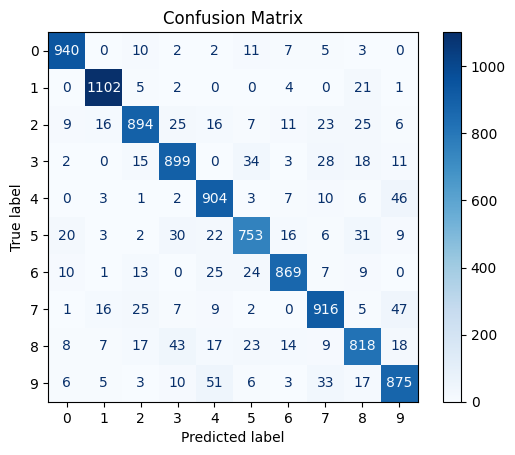

In [28]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()